# 02: Feature Importance and Waterfall Plots

> WaterFall plots were originally by Pak on the forums:

In [2]:
!pip install fastinference --quiet

     |████████████████████████████████| 21.9MB 61.4MB/s 
     |████████████████████████████████| 194kB 56.8MB/s 
     |████████████████████████████████| 276kB 57.7MB/s 
     |████████████████████████████████| 7.4MB 23.8MB/s 


In [3]:
from fastinference.tabular import *
from fastai2.tabular.all import *

## Initial Training

First let's start with tabular. Let's train a model real quick:

In [4]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')
splits = RandomSplitter()(range_of(df))
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
y_names = 'salary'

In [5]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, splits=splits)

In [6]:
dls = to.dataloaders()

In [7]:
learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)

In [8]:
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.364216,0.351531,0.835534,00:05


Now we can get into looking at the results! 

So what's new?

## Feature Importance

* Permutation-based approach

Take one column, shuffle it's innards, then measure the amount of change from your baseline:

In [ ]:
!pip install nbdev --quiet

In [24]:
doc(learn.feature_importance)

Calculating Permutation Importance


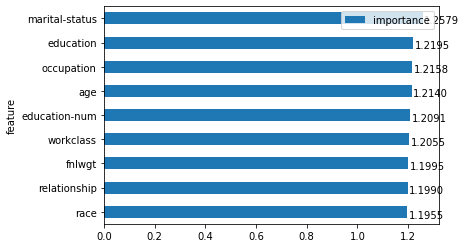

In [12]:
fi = learn.feature_importance()

In [13]:
fi

OrderedDict([('marital-status', 1.2578713225525318),
             ('education', 1.2194756852675324),
             ('occupation', 1.2158327107618543),
             ('age', 1.2140193734070588),
             ('education-num', 1.2090604934679),
             ('workclass', 1.2054794756774279),
             ('fnlwgt', 1.1994842362832698),
             ('relationship', 1.1990424935989235),
             ('race', 1.1955204865193385)])

If nothing is passed in, it will only work on the validation set:

Calculating Permutation Importance


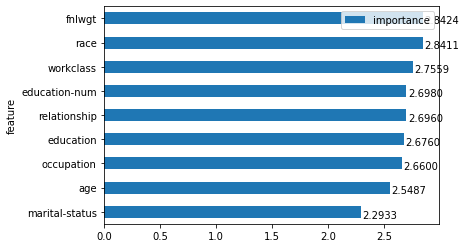

In [14]:
fi = learn.feature_importance(metric=CrossEntropyLossFlat())

In [15]:
fi

OrderedDict([('fnlwgt', 2.8423698591031497),
             ('race', 2.8411482107872152),
             ('workclass', 2.7559236935834064),
             ('education-num', 2.697999747683906),
             ('relationship', 2.6960493751374965),
             ('education', 2.6759744783236816),
             ('occupation', 2.660025329926414),
             ('age', 2.54867899780797),
             ('marital-status', 2.2933272240695515)])

So we can see based on what we want on our *metric* to be, our attention changes

In [16]:
test_dl = learn.dls.test_dl(df.iloc[:100])

Calculating Permutation Importance


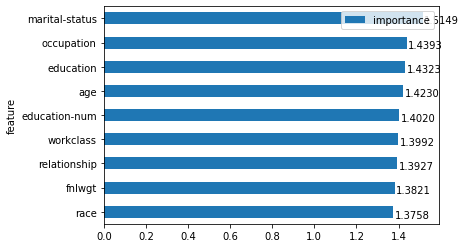

In [20]:
fi = learn.feature_importance(metric=RocAuc(), dl=test_dl)

Calculating Permutation Importance


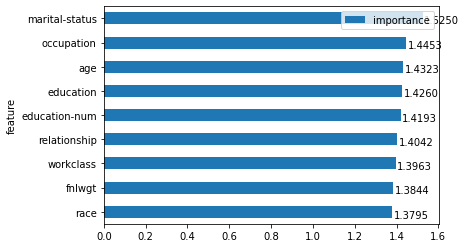

In [25]:
fi = learn.feature_importance(metric=RocAuc())

In [26]:
fi

OrderedDict([('marital-status', 1.525008927317592),
             ('occupation', 1.4453061514727585),
             ('age', 1.4323259691930847),
             ('education', 1.4260336603217458),
             ('education-num', 1.4192831918912956),
             ('relationship', 1.404225841763872),
             ('workclass', 1.3962565241924108),
             ('fnlwgt', 1.3844008788237283),
             ('race', 1.3795449398073136)])

## Dendrogram Plots and Correlation:

We can calculate how similar two variables are to each other by calculating what is known as the "correlation matrix"

In [31]:
doc(learn.get_top_corr_dict)

In [30]:
corr_dict = learn.get_top_corr_dict(df, thresh=0.3); corr_dict

OrderedDict([('workclass vs sex', 0.991),
             ('marital-status vs race', 0.506),
             ('education vs occupation', 0.493),
             ('fnlwgt vs education-num', 0.488),
             ('age vs education', 0.397),
             ('relationship vs race', 0.363),
             ('education-num vs race', 0.305)])

While this gives us a window, we can also plot the entire dendrogram and see the family:

In [33]:
doc(learn.plot_dendrogram)

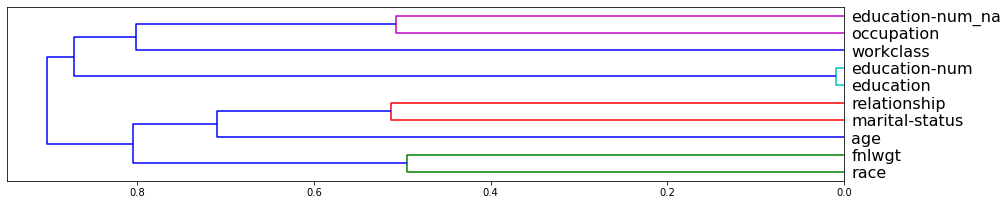

In [32]:
learn.plot_dendrogram(df)

## Waterfall Plots

Finally we can generate waterfall plots as well:

In [34]:
from fastinference.tabular.waterfall import *

In [35]:
doc(InterpretWaterfall)

In [36]:
cat_names, cont_names

(['workclass',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'education-num_na'],
 ['age', 'fnlwgt', 'education-num'])

In [37]:
fields = cat_names[:-1] + cont_names

In [40]:
df.iloc[5:6]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
5,20,Private,63210,HS-grad,9.0,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,15,United-States,<50k


In [41]:
wf = InterpretWaterfall(learn=learn, df=df, fields=fields, 
                        sampl_row=df.iloc[6], max_row_used=0.1)

In [42]:
wf.get_forces()

OrderedDict([('marital-status ( Divorced)', 0.10256808996200562),
             ('age (49)', -0.0391007661819458),
             ('relationship ( Other-relative)', 0.034265220165252686),
             ('occupation (nan)', -0.007673799991607666),
             ('education ( Some-college)', 0.007212460041046143),
             ('fnlwgt (44434)', -0.005041182041168213),
             ('education-num (10.0)', 0.003907203674316406),
             ('workclass ( Private)', 0.003746211528778076),
             ('race ( White)', -0.003280460834503174)])

In [43]:
wf.plot_forces()

We'll see how the work class affects this particular row:

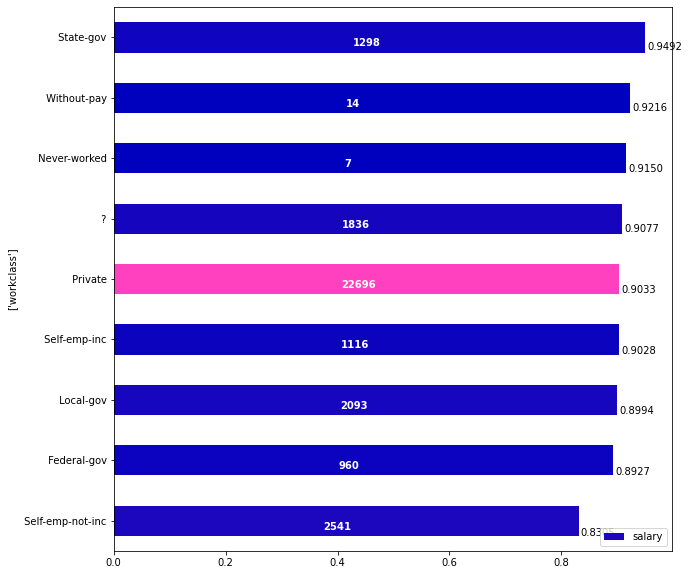

In [45]:
wf.plot_variants(fields=['workclass'])

In [47]:
doc(wf.get_variants_pd)

In [46]:
wf.get_variants_pd(fields=['age'])

,feature,salary,times
38,17.0,0.992132,395.0
32,18.0,0.991050,550.0
27,19.0,0.989888,712.0
22,20.0,0.988543,753.0
26,21.0,0.987075,720.0
...,...,...,...
35,53.0,0.903851,464.0
34,52.0,0.903466,478.0
31,49.0,0.903291,577.0
30,51.0,0.903195,595.0
